In [16]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [17]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [18]:
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')
# Pull pricing data for 3 more BTC exchanges
# ADD YALE/SPCOMP
exchanges = ['COINBASE','BITSTAMP','ITBIT']


exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    if exchange == 'SPCOMP':
        exchange_code = 'YALE/{}'.format(exchange)
    else:    
        exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/KRAKENUSD from cache
Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [19]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

In [20]:
df = exchange_data['KRAKEN']
print(df.head())

                 Open       High        Low      Close  Volume (BTC)  \
Date                                                                   
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
Date                                           
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709  


In [21]:
style.use('ggplot')


df = df[['Open',  'High',  'Low',  'Close', 'Volume (BTC)']]
#High - low percentage change
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
#daily percentage change
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

C:\Users\Luisk8nj\Documents\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume (BTC)']]
forecast_col = 'Close'
df.fillna(value=-99999, inplace=True)

#forecast the smallest returns the smallest (closest to negative infinity) double value that is greater than or equal to the argument and is equal to a mathematical integer.
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

print(df.head())

                Close     HL_PCT  PCT_change  Volume (BTC)      label
Date                                                                 
2014-01-07  810.00000  10.131794   -7.393688     15.622378  830.88999
2014-01-08  824.98287  13.556986    1.849737     19.182756  830.88897
2014-01-09  841.86934   7.433358    1.975123      8.158335  803.01935
2014-01-10  857.33056   4.705368    2.064377      8.024510  812.02000
2014-01-11  899.84105   6.766658    4.852138     18.748285  826.72139


In [23]:
# Assign the data to X and y

X = df[['HL_PCT', 'PCT_change', 'Volume (BTC)']]
y = df["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(1472, 3) (1472, 1)


In [24]:
# Use train_test_split to create training and testing data

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

### END SOLUTION

In [25]:
# Create the model using LinearRegression

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
### END SOLUTION

In [26]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.22610595814848677
Testing Score: 0.14349487907661485


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

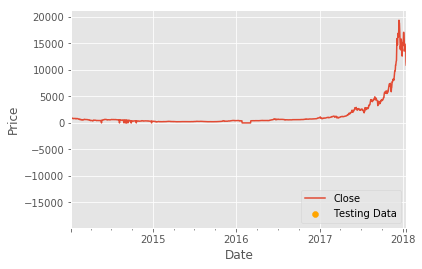

In [28]:
### BEGIN SOLUTION
# plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
# plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
# plt.legend()
# plt.hlines(y=0, xmin=y.min(), xmax=y.max())
# plt.title("Residual Plot")
### END SOLUTION

df['Close'].plot()
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [29]:
# plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
# plt.legend()
# plt.hlines(y=0, xmin=y.min(), xmax=y.max())
# plt.title("Residual Plot")

print(X_test)

                  HL_PCT    PCT_change  Volume (BTC)
Date                                                
2017-09-01      4.427732      3.860655   4476.539582
2017-08-26      2.780491     -0.905180   2665.751145
2014-07-29      3.874011     -0.561122      2.678287
2014-07-15      0.000000      0.000000      0.180000
2014-05-04      3.221181      1.211175      1.771691
2015-08-08      9.302540     -5.737157     29.299671
2016-05-01      1.685130      0.705719    286.453712
2017-03-17     17.744526    -12.354304   8378.760569
2015-08-04      2.485656      1.761064     21.607238
2015-06-14      0.905533      0.062500     18.232946
2015-10-12      1.266207     -0.437137     28.364136
2016-04-12      1.724356      0.877069   1155.986383
2016-09-01      1.182692     -0.384877   1005.531437
2014-02-27      8.281833     -0.420738     45.766694
2015-09-25      2.052898      1.086682    142.009048
2015-06-22      1.650473      1.552312     39.365095
2014-05-26      4.360735      2.156435     10.

In [30]:
#x value is all data frame, drop label, 
X = np.array(df.drop(['label'], 1))
#normalize with other data points, scale new value a long side other values
X = preprocessing.scale(X)
#x_lately is what we are going to predict
X_lately = X[-forecast_out:]
#redifine x where wwe are able to forecast out x(last 30 days)
X = X[:-forecast_out]

df.dropna(inplace=True)
#value of Y are the labels(price)
y = np.array(df['label'])
#20% of data as testing data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

#fit clasifier 
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
#square error (directional accurate)
print(accuracy)

#next 30 days with forecast set of prices
forecast_set = clf.predict(X_lately)

df['Forecast'] = np.nan
#find out last date from data
last_date = df.iloc[-1].name

last_unix = last_date.timestamp()
#seconds in one day
one_day = 86400

next_unix = last_unix + one_day

0.872771167113


In [36]:
#populate dataframe with new dates and forecast value
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [37]:
trace_high = go.Scatter(
                x=df.index,
                y=df['Close'],
                name = "Close",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_low = go.Scatter(
                x=df.index,
                y=df['Forecast'],
                name = "Forecast",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [trace_high,trace_low]

layout = dict(
    title = "Bitcoin Closing Prices",
    xaxis = dict(
        range = ['2014-07-01','2018-2-28'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Bitcoin Closing Prices")

In [38]:
df['Forecast'].tail()

Date
2018-02-12    14777.002558
2018-02-13    14232.284816
2018-02-14    14232.253656
2018-02-15    12245.910551
2018-02-16    11772.533565
Name: Forecast, dtype: float64